In [ ]:
%%capture

# Libraries
!pip install lifelines
!pip install shap
!pip install optuna
!pip install cmaes
!pip install scikit-survival

In [ ]:
# Imports
seed = 1

import os
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics import roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, brier_score
from sksurv.nonparametric import kaplan_meier_estimator

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler

import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# **Functions**

In [ ]:
# Importing the functions
!gdown 1-uw7N4Vx5eNLso_NQ64uObFTlwXhdnda --quiet

from functions_ml_survival import *

# **Comparison of survival models**

## **Train e Test**



In [ ]:
# Colorectal Dataset
!gdown 1yzI52UDZyac0QGWmKL5Mai1JOqWUTeMQ --quiet

In [ ]:
# Reading Data
df_colo = pd.read_csv('colorretal.csv')
print(df_colo.shape)
df_colo.head(3)

(44857, 49)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,EC,ECGRUP,...,TRATCONS_CAT,DIAGTRAT_CAT,PRESENCA_META,PRESENCA_REC,obito_geral,obito_cancer,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5,meses_diag
0,612374,9,91,2,3550308,2,2,C209,IIA,II,...,0,1,0,0,0,0,1,0,0,23
1,8,9,79,2,3550308,9,1,C180,II,II,...,0,0,0,0,0,0,1,1,1,61
2,8,9,59,2,3534401,9,2,C209,II,II,...,0,0,0,1,0,0,1,1,1,61


In [ ]:
# Columns
df_colo.columns

Index(['INSTITU', 'ESCOLARI', 'IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV',
       'TOPO', 'EC', 'ECGRUP', 'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO',
       'HORMONIO', 'IMUNO', 'OUTROS', 'NENHUMAPOS', 'CIRURAPOS', 'RADIOAPOS',
       'QUIMIOAPOS', 'HORMOAPOS', 'IMUNOAPOS', 'OUTROAPOS', 'ULTINFO',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'DSCINST',
       'IBGEATEN', 'HABILIT2', 'DRS_INST', 'RRAS_INST', 'ECGRUP_CAT',
       'ULTIDIAG', 'CONSDIAG_CAT', 'TRATCONS_CAT', 'DIAGTRAT_CAT',
       'PRESENCA_META', 'PRESENCA_REC', 'obito_geral', 'obito_cancer',
       'sobrevida_ano1', 'sobrevida_ano3', 'sobrevida_ano5', 'meses_diag'],
      dtype='object')

In [ ]:
# Data Splitting into Training and Testing Sets
# Separate features (X) and target variable (y)
X = df_colo.drop(['obito_geral'], axis=1)  # Features (all columns except 'obito_geral')
y = df_colo['obito_geral']  # Target variable ('obito_geral')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  # 80% train, 20% test
                                                    random_state=seed,  # For reproducibility
                                                    stratify=y)  # Stratified sampling to maintain class proportions

# Print the shapes of the resulting datasets
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (35885, 48)
y_train: (35885,)
X_test: (8972, 48)
y_test: (8972,)


In [ ]:
# Saving the Datasets
# Concatenate features and target variable for training and testing sets
df_treino = pd.concat([X_train, y_train], axis=1)  # Combine X_train and y_train into a single DataFrame
df_teste = pd.concat([X_test, y_test], axis=1)  # Combine X_test and y_test into a single DataFrame

df_treino.to_csv('colorretal_treino.csv', index=False) # Save the training DataFrame to 'colorretal_treino.csv'
df_teste.to_csv('colorretal_teste.csv', index=False)  # Save the testing DataFrame to 'colorretal_teste.csv'

## **Kaplan-Meier**

In [ ]:
# Reading Test Data
df_teste = pd.read_csv('colorretal_teste.csv')  # Load the test data from the CSV file
print(df_teste.shape)  # Print the dimensions of the test DataFrame
df_teste.head(3)  # Display the first 3 rows of the test DataFrame

(8972, 49)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,EC,ECGRUP,...,TRATCONS_CAT,DIAGTRAT_CAT,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5,meses_diag,obito_geral
0,21636,2,67,1,3516705,2,1,C185,IIIB,III,...,1,0,0,0,0,1,1,1,61,0
1,19488,2,46,2,3552205,2,1,C188,IIIB,III,...,0,0,0,1,0,1,0,0,33,0
2,612374,2,66,2,3534401,9,2,C209,IIA,II,...,0,2,0,0,0,1,1,1,61,0


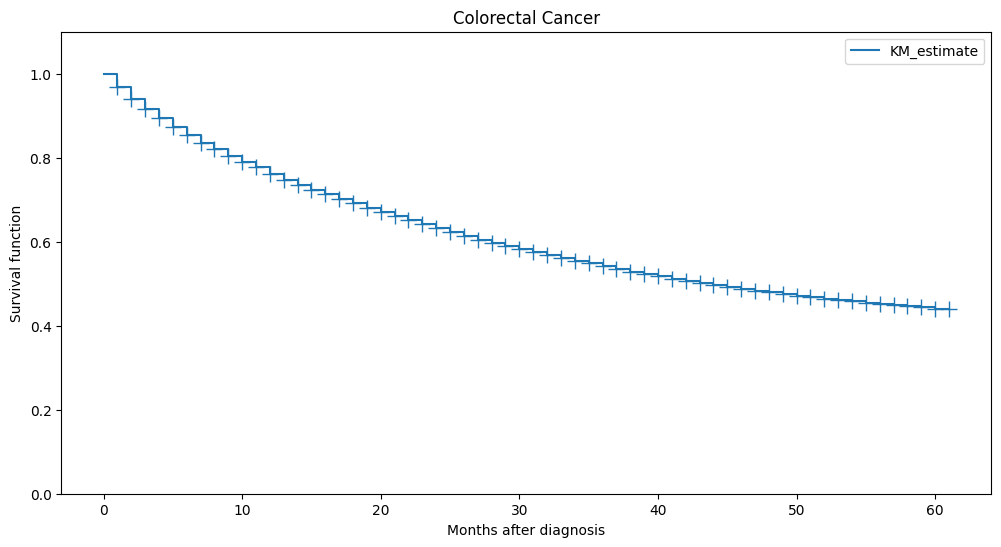

In [ ]:
# Kaplan-Meier Survival Curve Plot
# Extract event (E) and time (T) data from the test set
E = (df_teste.obito_geral == 1)  # Event indicator (obito_geral = 1 means event occurred)
T = df_teste.meses_diag  # Time to event (months since diagnosis)

title = f'Colorectal Cancer'  # Set the plot title

kmf = KaplanMeierFitter()  # Initialize the Kaplan-Meier fitter

fig = plt.figure(figsize=(12, 6))  # Create the plot figure
ax = plt.subplot(111)  # Create the axes for the plot

# Fit and plot the Kaplan-Meier survival curve
ax = kmf.fit(T, E).plot(ax=ax, ci_show=False, show_censors=True)  # Fit the model, plot the curve, show censoring marks
ax.set_title(title)  # Set the plot title
ax.set_xlabel('Months after diagnosis')  # Set the x-axis label
ax.set_ylabel('Survival function')  # Set the y-axis label
plt.ylim([0, 1.1])  # Set y-axis limits
plt.show()  # Display the plot

In [ ]:
# Survival at 1, 3, and 5 Years
# Access survival probabilities at specific time points (12, 36, and 60 months)
kmf.survival_function_.loc[[12, 36, 60]]

,KM_estimate
timeline,
12.0,0.762278
36.0,0.541013
60.0,0.440833


## **Machine Learning Survival**

### **Data preparation for survival models**

In [ ]:
# Reading Training Data
df_treino = pd.read_csv('colorretal_treino.csv')  # Load the training data from the CSV file
print(df_treino.shape)  # Print the dimensions of the training DataFrame
df_treino.head(3)  # Display the first 3 rows of the training DataFrame

(35885, 49)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,EC,ECGRUP,...,TRATCONS_CAT,DIAGTRAT_CAT,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5,meses_diag,obito_geral
0,22128,2,71,1,3549805,2,1,C186,IIA,II,...,0,0,0,0,0,0,0,0,1,1
1,16624,9,73,2,3550308,2,2,C209,IV,IV,...,2,2,1,0,1,1,0,0,26,1
2,16675,4,87,2,3550308,1,1,C209,IVB,IV,...,0,0,1,0,1,1,0,0,13,1


In [ ]:
# Reading Test Data
df_teste = pd.read_csv('colorretal_teste.csv')  # Load the test data from the CSV file
print(df_teste.shape)  # Print the dimensions of the test DataFrame
df_teste.head(3)  # Display the first 3 rows of the test DataFrame

(8972, 49)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,EC,ECGRUP,...,TRATCONS_CAT,DIAGTRAT_CAT,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5,meses_diag,obito_geral
0,21636,2,67,1,3516705,2,1,C185,IIIB,III,...,1,0,0,0,0,1,1,1,61,0
1,19488,2,46,2,3552205,2,1,C188,IIIB,III,...,0,0,0,1,0,1,0,0,33,0
2,612374,2,66,2,3534401,9,2,C209,IIA,II,...,0,2,0,0,0,1,1,1,61,0


In [ ]:
# Exclude the row where ULTDIAG is negative
df_treino = df_treino[df_treino.ULTIDIAG >= 0]

df_treino.shape

(35884, 49)

In [ ]:
# Y train and test for survival data (Death, Months from Diagnosis)
y_train = Surv.from_arrays(df_treino.obito_geral, df_treino.meses_diag)  # Create survival data for training set
y_test = Surv.from_arrays(df_teste.obito_geral, df_teste.meses_diag)  # Create survival data for test set

In [ ]:
# X train and test after removing unnecessary columns, including Death and Months from Diagnosis (which go to the target Y)
list_drop = ['obito_cancer', 'sobrevida_ano1', 'sobrevida_ano3', 'sobrevida_ano5',
             'meses_diag', 'obito_geral', 'ECGRUP', 'NENHUM', 'CIRURGIA', 'RADIO',
             'QUIMIO', 'HORMONIO', 'IMUNO', 'OUTROS', 'NENHUMAPOS', 'CIRURAPOS',
             'RADIOAPOS', 'QUIMIOAPOS', 'HORMOAPOS', 'IMUNOAPOS', 'OUTROAPOS',
             'ULTINFO', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RRAS', 'DSCINST',
             'RRAS_INST', 'ECGRUP_CAT', 'ULTIDIAG', 'CONSDIAG_CAT', 'PRESENCA_META',
             'PRESENCA_REC']

X_train = df_treino.drop(list_drop, axis=1)  # Remove specified columns from the training dataset

X_test = df_teste.drop(list_drop, axis=1)  # Remove specified columns from the test dataset

In [ ]:
# Preprocessing of Training and Test data
X_train, X_test, feat_cols, enc, norm = preprocessing(X_train, X_test,
                                                      norm_name='StandardScaler',  # Specify normalization method
                                                      return_enc_norm=True,  # Return encoder and normalizer objects
                                                      random_state=seed)  # Set random state for reproducibility

# Display the shapes of the processed training and test datasets
X_train.shape, X_test.shape

((35884, 16), (8972, 16))

In [ ]:
# Features columns
feat_cols

Index(['INSTITU', 'ESCOLARI', 'IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV',
       'TOPO', 'EC', 'ANODIAG', 'DRS', 'IBGEATEN', 'HABILIT2', 'DRS_INST',
       'TRATCONS_CAT', 'DIAGTRAT_CAT'],
      dtype='object')

### **Random Survival Forest**

#### **Base Model**

In [ ]:
# RSF (Random Survival Forest) Model
rsf = RandomSurvivalForest(max_depth=8, n_jobs=-1, random_state=seed)  # Initialize the RSF model with a max depth of 8
rsf.fit(X_train, y_train)  # Train the model using the training data

# Calculate the C-index for the test dataset
c_index_base = rsf.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_base}')
print(f'C-Index Train: {rsf.score(X_train, y_train)}')

C-Index Test: 0.7517176452336831
C-Index Train: 0.7631437582576479


C-Index IPCW Test: 0.745620186422011
C-Index IPCW Train: 0.7559101078319814

Integrated Brier Score (IBS): 0.15858274688494192

Brier Score:
    > 1 year = 0.13946323413511666
    > 3 years = 0.17947370726051814
    > 5 years = 0.17947388519927296



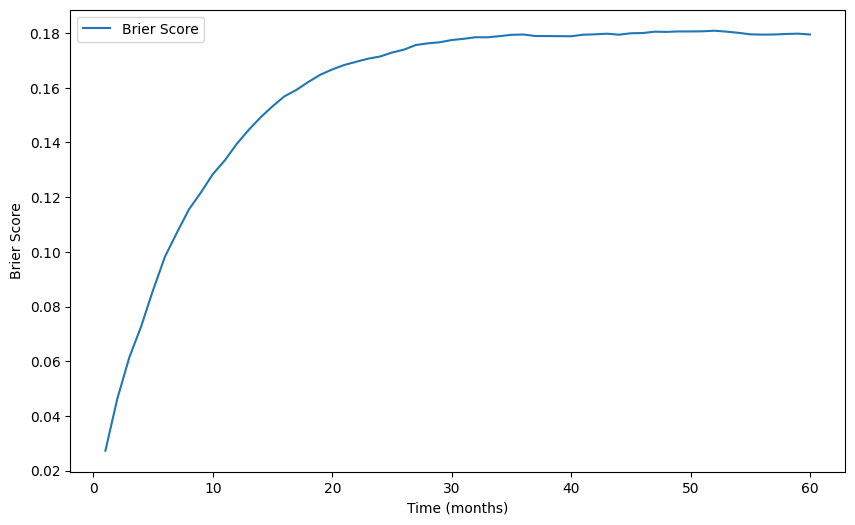

In [ ]:
# C-Index IPCW and Brier Score
c_index_ipcw_brier_score(rsf, X_train, y_train, X_test, y_test)  # Compute and evaluate the IPCW C-index and Brier Score

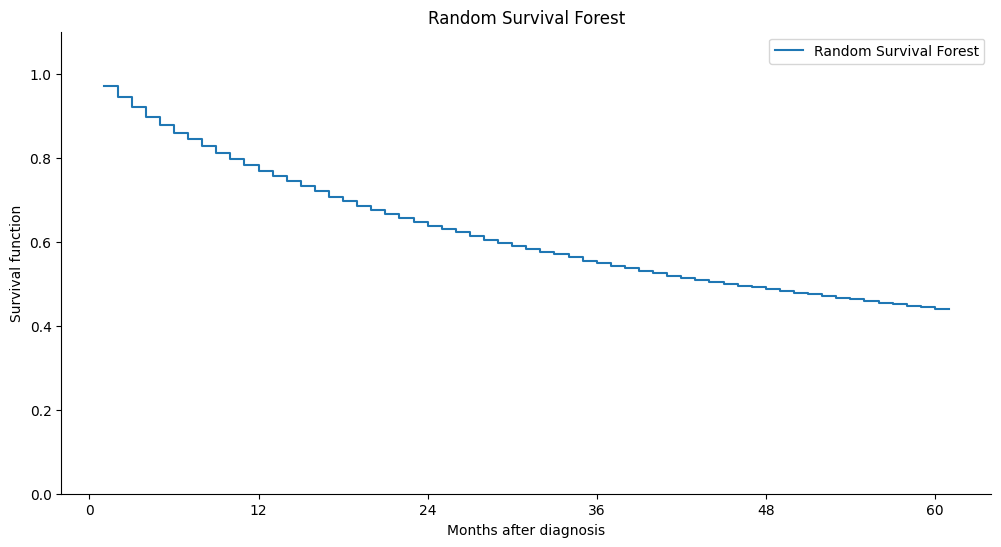

In [ ]:
# Survival prediction (Probability)
surv_rsf = rsf.predict_survival_function(X_test, return_array=True)  # Predict survival probabilities for the test set
surv_rsf_mean = surv_rsf.mean(axis=0)  # Compute the mean survival probability across samples

# Plot the predicted survival curve
name = 'Random Survival Forest'

plot_survival_curve(rsf.unique_times_, surv_rsf_mean, name=name)  # Generate and display the survival curve

In [ ]:
# Survival probability at 12, 36, and 60 months
print(f'12 months: {surv_rsf_mean[12]}')  # Print survival probability at 12 months
print(f'36 months: {surv_rsf_mean[36]}')  # Print survival probability at 36 months
print(f'60 months: {surv_rsf_mean[60]}')  # Print survival probability at 60 months

12 months: 0.7569640634742844
36 months: 0.5426954903578372
60 months: 0.4404515816400029


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=seed)  # Create a 10-fold cross-validation strategy

# Function to compute the C-index for a given estimator
def c_index(estimator, X, y):
    cindex = estimator.score(X, y)  # Compute the C-index score
    return cindex

# Objective function for hyperparameter optimization
def objective(trial):
    # Define hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 130)  # Number of trees in the forest
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Maximum depth of each tree
    min_samples_split = trial.suggest_int('min_samples_split', 3, 12)  # Min samples required to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 12)  # Min samples required at a leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.75, 1.0])  # Feature selection strategy
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])  # Whether to use bootstrap sampling

    # Create and train the model with the suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=seed,
        n_jobs=-1
    )

    # Perform cross-validation and return the mean C-index score
    return cross_val_score(rsf, X_train, y_train, cv=kf, scoring=c_index).mean()

**RandomSampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'opt_rsf_rand.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),
                                study_name='RSF_RandomSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 19.5 ms, sys: 969 µs, total: 20.5 ms
Wall time: 20.4 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 116, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_rand = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_rand.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_rand = rsf_rand.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {rsf_rand.score(X_train, y_train)}')

C-Index Test: 0.7547371017603656
C-Index Train: 0.7797215136399612


**TPESampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'opt_rsf_tpe.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),
                                study_name='RSF_TPESampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 28 ms, sys: 968 µs, total: 28.9 ms
Wall time: 32.9 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 89, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_tpe = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_tpe.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_tpe = rsf_tpe.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {rsf_tpe.score(X_train, y_train)}')

C-Index Test: 0.7545059354114757
C-Index Train: 0.7781420858503447


**CmaEsSampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'opt_rsf_cma.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),
                                study_name='RSF_CmaEsSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 19.8 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 114, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_cma = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_cma.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_cma = rsf_cma.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_cma}')
print(f'C-index Train: {rsf_cma.score(X_train, y_train)}')

C-Index Test: 0.7547223268139652
C-index Train: 0.7797459525248217


#### **Best Random Survival Forest Model**

In [ ]:
# Best RSF model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for different models
models = [rsf, rsf_rand, rsf_tpe, rsf_cma]  # List of the corresponding models

# Find the index of the model with the highest C-index score
id_best_score = scores.index(max(scores))
best = models[id_best_score]  # Select the model with the best score

# Print the best model
print(best)

RandomSurvivalForest(bootstrap=False, max_depth=10, max_features='log2',
                     min_samples_leaf=9, min_samples_split=9, n_estimators=116,
                     random_state=1)


C-Index Test: 0.7547371017603656
C-Index Train: 0.7797215136399612

C-Index IPCW Test: 0.7489074752081806
C-Index IPCW Train: 0.7734233170546435

Integrated Brier Score (IBS): 0.15554500214918685

Brier Score:
    > 1 year = 0.13744132278481827
    > 3 years = 0.17567015830959912
    > 5 years = 0.17596705641278645



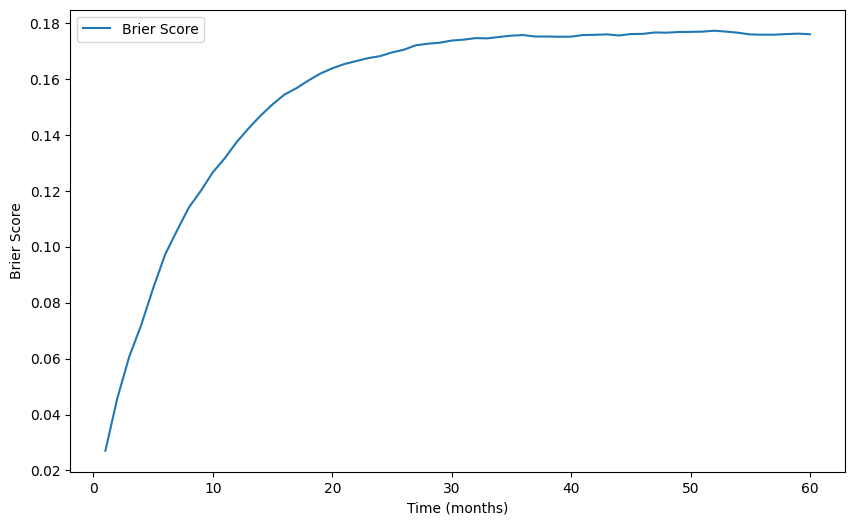

In [ ]:
# Metrics of the best RSF model
final_c_index = best.score(X_test, y_test)  # Compute the final C-index for the test dataset

# Print the C-index for both test and training datasets
print(f'C-Index Test: {final_c_index}')
print(f'C-Index Train: {best.score(X_train, y_train)}\n')

# Compute and display the IPCW C-index and Brier Score for the best model
c_index_ipcw_brier_score(best, X_train, y_train, X_test, y_test)

In [ ]:
# Best features by permutation importance
calculate_permutation_importance(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.165104,0.003059
IDADE,0.027507,0.001610
CATEATEND,0.014188,0.001299
DIAGTRAT_CAT,0.009172,0.001097
TRATCONS_CAT,0.007497,0.000773
INSTITU,0.007339,0.000603
DIAGPREV,0.002896,0.000553
TOPO,0.002624,0.000252
ANODIAG,0.002610,0.000255
IBGEATEN,0.002371,0.000209


PermutationExplainer explainer: 8973it [1:35:57,  1.56it/s]                          


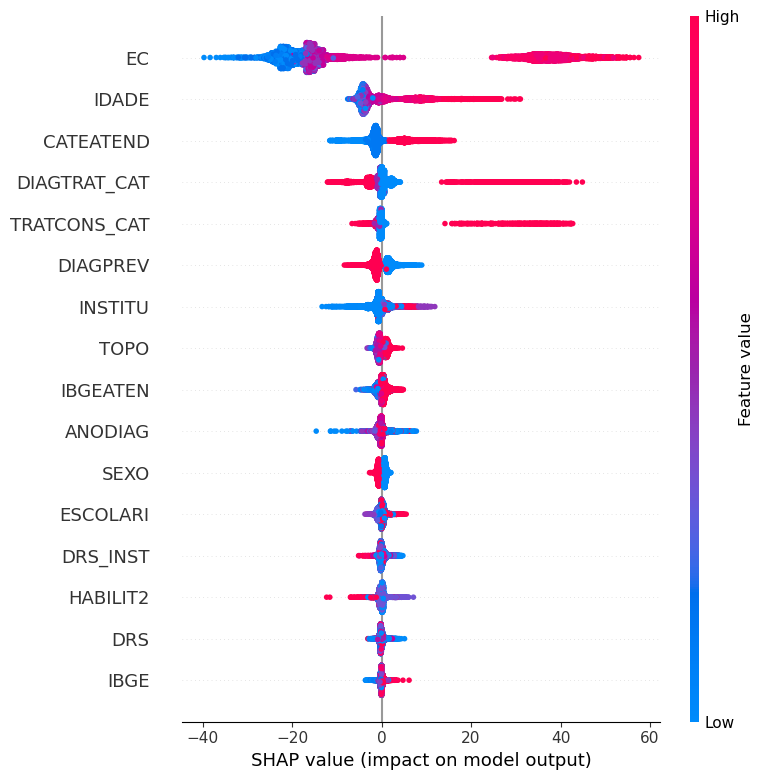

In [ ]:
# Best features by SHAP
explainer = shap.Explainer(best.predict, X_train, seed=seed,  # Create a SHAP explainer for the best model
                           output_names=feat_cols,  # Specify the feature names
                           n_jobs=-1)  # Use multiple jobs for parallel computation

shap_values = explainer(X_test)  # Calculate SHAP values for the test set

# Plot the SHAP summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

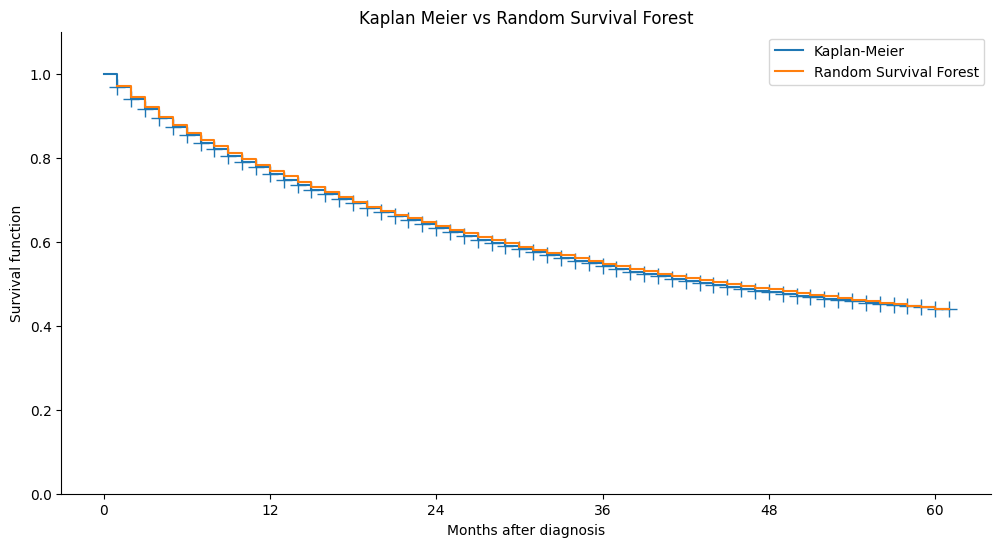

In [ ]:
# Comparison of survival curves
name = 'Random Survival Forest'  # Name of the model to be displayed on the plot

# Predict survival functions for the test set and compute the mean survival function
surv_rsf = best.predict_survival_function(X_test, return_array=True)
surv_rsf_mean = surv_rsf.mean(axis=0)  # Compute the mean survival function across all samples

# Plot the survival curve and compare with Kaplan-Meier (KM) estimates
plot_survival_curve(best.unique_times_, surv_rsf_mean,
                    name=name, compare_km=True, test_df=df_teste)  # Plot the survival curve and compare with the test dataset

### **Survival SVM**

#### **Base Model**

In [ ]:
# SurvivalSVM Model
ssvm = FastSurvivalSVM(random_state=seed)  # Initialize the FastSurvivalSVM model with a fixed random state

ssvm.fit(X_train, y_train)  # Train the model on the training data

c_index_base = ssvm.score(X_test, y_test)  # Calculate the C-index on the test dataset

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_base}')
print(f'C-Index Train: {ssvm.score(X_train, y_train)}')

C-Index Test: 0.7088418088812972
C-Index Train: 0.7140363897668406


In [ ]:
# C-Index IPCW
surv_risks = ssvm.predict(X_test)  # Predict survival risks for the test dataset
surv_risks_train = ssvm.predict(X_train)  # Predict survival risks for the training dataset

# Calculate the IPCW C-index for both test and training datasets
c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)

# Print the IPCW C-index for both test and training datasets
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')

C-Index IPCW Test: 0.7035689517806478
C-Index IPCW Train: 0.7080728430532489


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(10, shuffle=True, random_state=seed)  # Create a KFold cross-validator with 10 splits, shuffling, and a fixed random seed

def c_index(estimator, X, y):
    cindex = estimator.score(X, y)  # Compute the C-index of the estimator on the dataset
    return cindex

def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'alpha': trial.suggest_categorical('alpha', [1e-3, 1e-2, 1e-1, 1, 10]),  # Suggest different values for the alpha regularization parameter
        'rank_ratio': trial.suggest_float('rank_ratio', 0.1, 1.0, step=0.05),  # Suggest a value for the rank ratio
        'tol': trial.suggest_categorical('tol', [1e-5, 1e-4, 1e-3, 1e-2]),  # Suggest tolerance values for convergence
    }

    # Train the model with the suggested parameters
    ssvm = FastSurvivalSVM(**param, random_state=seed)

    return cross_val_score(ssvm, X_train, y_train, cv=kf, scoring=c_index).mean()  # Return the mean cross-validated C-index score

**RandomSampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'colo_opt_svm_rand.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create a new Optuna study
                                study_name='SSVM_RandomSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 21.5 ms, sys: 2.96 ms, total: 24.4 ms
Wall time: 26.6 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 0.1, 'rank_ratio': 0.25, 'tol': 0.0001}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_rand = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_rand.fit(X_train, y_train)  # Train the model on the training data

c_index_rand = ssvm_rand.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {ssvm_rand.score(X_train, y_train)}')

C-Index Test: 0.7088417511666628
C-Index Train: 0.7140349299888415


**TPESampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'colo_opt_svm_tpe.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create a new Optuna study using TPE sampler
                                study_name='SSVM_TPESampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 31.5 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 0.1, 'rank_ratio': 0.25, 'tol': 0.0001}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_tpe = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_tpe.fit(X_train, y_train)  # Train the model on the training data

c_index_tpe = ssvm_tpe.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {ssvm_tpe.score(X_train, y_train)}')

C-Index Test: 0.7088417511666628
C-Index Train: 0.7140349299888415


**CmaEsSampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'colo_opt_svm_cma.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create a new Optuna study using CMA-ES sampler
                                study_name='SSVM_CmaEsSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 13.5 ms, sys: 0 ns, total: 13.5 ms
Wall time: 13.5 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 0.1, 'rank_ratio': 0.25, 'tol': 0.0001}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_cma = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_cma.fit(X_train, y_train)  # Train the model on the training data

c_index_cma = ssvm_cma.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_cma}')
print(f'C-Index Train: {ssvm_cma.score(X_train, y_train)}')

C-Index Test: 0.7088417511666628
C-Index Train: 0.7140349299888415


#### **Best Survival SVM Model**

In [ ]:
# Best SSVM model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for different models
models = [ssvm, ssvm_rand, ssvm_tpe, ssvm_cma]  # List of corresponding SSVM models

id_best_score = scores.index(max(scores))  # Identify the index of the model with the highest C-index score
best = models[id_best_score]  # Select the model with the best performance

print(best)  # Print the best model

FastSurvivalSVM(optimizer='avltree', random_state=1)


In [ ]:
# C-Index Calculation
print('C-Index')
print(f'> Test: {best.score(X_test, y_test)}')  # Calculate and print the C-index for the test set
print(f'> Train: {best.score(X_train, y_train)}')  # Calculate and print the C-index for the training set

# C-Index IPCW Calculation
surv_risks = best.predict(X_test)  # Predict survival risks for the test set
surv_risks_train = best.predict(X_train)  # Predict survival risks for the training set

# Compute IPCW C-index for test and train sets
c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)  # IPCW C-index for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)  # IPCW C-index for the train set

print('\nC-Index IPCW')
print(f'> Test: {c_index_ipcw[0]}')  # Print the IPCW C-index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print the IPCW C-index for the training set

C-Index
> Test: 0.7088418088812972
> Train: 0.7140363897668406

C-Index IPCW
> Test: 0.7035689517806478
> Train: 0.7080728430532489


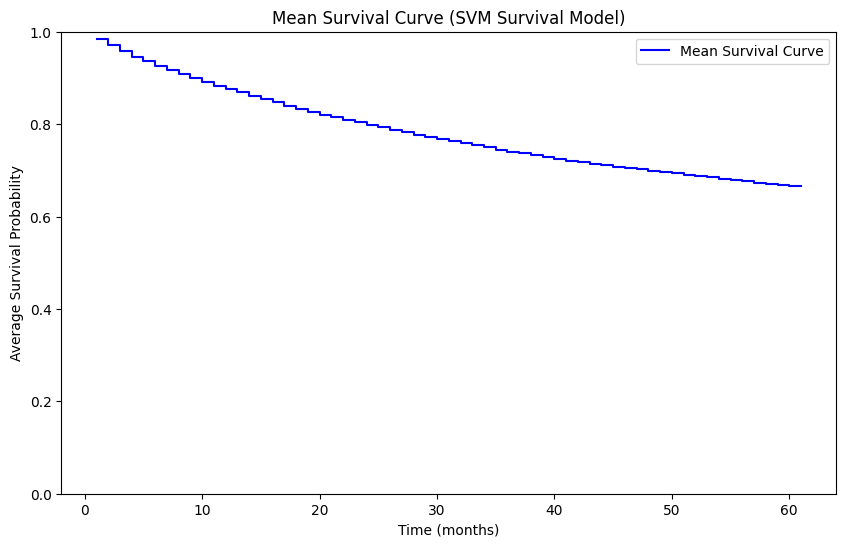

In [ ]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (SVM Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at 12 months: 0.1845
Brier Score at 36 months: 0.2605
Brier Score at 60 months: 0.2657

Integrated Brier Score (IBS): 0.2253


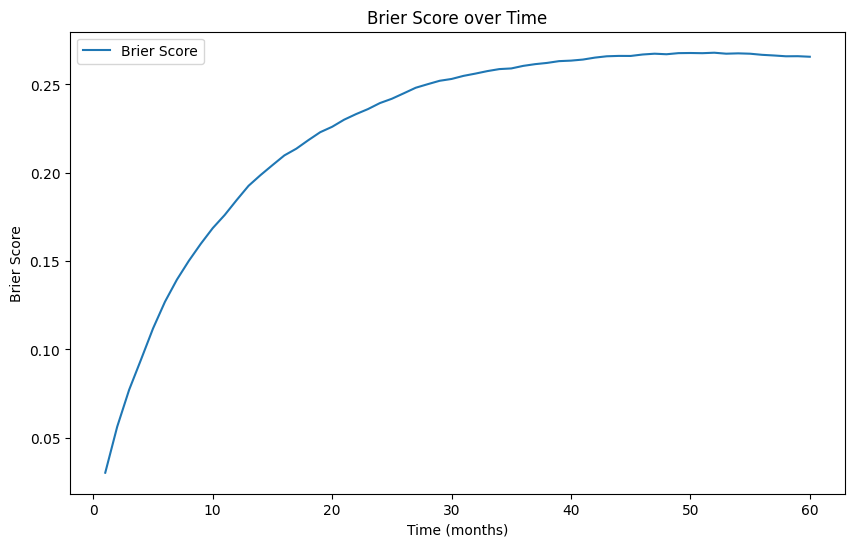

In [ ]:
# Time points for the calculation
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure alignment of survival probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)

# Adjust probabilities for the desired time points (row by row)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])
    for i in range(survival_probabilities.shape[0])
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the index of the closest time in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]

    # Get the actual observations
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for time t
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numeric value

    print(f"Brier Score at {t} months: {brier[1][0]:.4f}")

# Calculate the Brier Score over time for the IBS
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS)
time_differences = np.diff(np.hstack([[0], time_points]))
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, brier_scores[1], label="Brier Score")
plt.xlabel("Time (months)")
plt.ylabel("Brier Score")
plt.title("Brier Score over Time")
plt.legend()
plt.show()

In [ ]:
# Best features by permutation importance
calculate_permutation_importance(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.161662,0.003115
IDADE,0.022160,0.001788
CATEATEND,0.016051,0.001550
TRATCONS_CAT,0.006716,0.000640
DIAGPREV,0.006185,0.000821
IBGEATEN,0.000990,0.000358
HABILIT2,0.000844,0.000289
SEXO,0.000771,0.000251
DRS,0.000155,0.000127
INSTITU,0.000061,0.000072


PermutationExplainer explainer: 8973it [02:54, 49.63it/s]                          


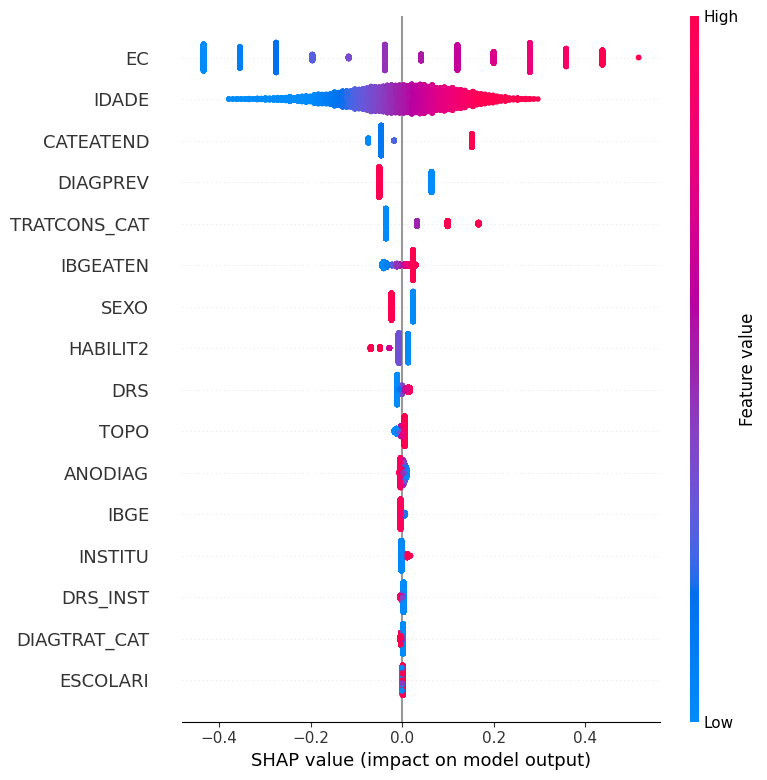

In [ ]:
# Best features by SHAP
explainer = shap.Explainer(best.predict, X_train, seed=seed,  # Create a SHAP explainer for the best model
                           output_names=feat_cols,  # Specify the feature names
                           n_jobs=-1)  # Use multiple jobs for parallel computation

shap_values = explainer(X_test)  # Calculate SHAP values for the test set

# Plot the SHAP summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

### **XGBoost**

#### **Base Model**

In [ ]:
# XGBoost Model
weights = np.where(y_train['event'], 1.0, 0.25)  # Assigning weights to the training data based on event status (1.0 for events, 0.25 for censored)

dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # Prepare the training dataset for XGBoost, including weights and time as the target
dtest = xgb.DMatrix(X_test)  # Prepare the test dataset for prediction

# Training the XGBoost model for survival analysis
params = {
    'objective': 'survival:cox',  # Specify Cox proportional hazards objective for survival analysis
    'eval_metric': 'cox-nloglik',  # Use negative log-likelihood as the evaluation metric
    'max_depth': 3,  # Set the maximum depth of trees
    'seed': seed,  # Set random seed for reproducibility
}
xgboost = xgb.train(params, dtrain, num_boost_round=100)  # Train the XGBoost model with 100 boosting rounds

# Make predictions and calculate C-Index for Test data
y_pred = xgboost.predict(dtest)  # Predict survival times for the test set
c_index_base = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # Calculate C-Index for the test data

# Make predictions and calculate C-Index for Training data
y_pred_train = xgboost.predict(dtrain)  # Predict survival times for the training set
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # Calculate C-Index for the training data

# Display C-Index for Test and Train data
print(f'C-index Test: {c_index_base}')  # Print the C-Index for the test data
print(f'C-index Train: {c_index_train}')  # Print the C-Index for the training data

C-index Test: 0.7230960538503702
C-index Train: 0.7358208866376148


In [ ]:
# C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = xgboost.predict(dtest)  # Predict the survival risks for the test set
surv_risks_train = xgboost.predict(dtrain)  # Predict the survival risks for the training set

# Calculate the C-Index IPCW for Test and Train data
c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)  # Compute the C-Index IPCW for the test data
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)  # Compute the C-Index IPCW for the training data

# Display C-Index IPCW for Test and Train data
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')  # Print the C-Index IPCW for the test data
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')  # Print the C-Index IPCW for the training data

C-Index IPCW Test: 0.7178736764045426
C-Index IPCW Train: 0.7286902448291874


#### **Optuna**

In [ ]:
# Optuna number o trials
n_trials = 150

In [ ]:
# Folds for Cross-Validation
kf = KFold(10, shuffle=True, random_state=seed)  # Create 10-fold cross-validation with shuffling
c_index_list = []  # List to store the C-index values from each fold

def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),  # Number of estimators (trees)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25, step=0.01),  # Learning rate
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Maximum depth of trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum weight of child nodes
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),  # Fraction of data used for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),  # Fraction of features used per tree
        # 'reg_alpha': trial.suggest_categorical('reg_alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),  # L1 regularization term
        # 'reg_lambda': trial.suggest_categorical('reg_lambda', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),  # L2 regularization term
        'objective': 'survival:cox',  # Cox loss function for survival analysis
        'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
        'random_state': seed,  # Seed for reproducibility
        'n_jobs': -1,  # Use all available cores for training
    }

    # Loop over the folds in cross-validation
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data into training and validation sets for the current fold
        X_t, X_v = X_train[train_idx], X_train[valid_idx]  # Split features
        y_t, y_v = y_train[train_idx], y_train[valid_idx]  # Split labels

        # Create DMatrix for training and validation (DMatrix is an optimized data structure for XGBoost)
        dtrain = xgb.DMatrix(X_t, label=y_t['time'], weight=np.where(y_t['event'], 1.0, 0.25))  # Set event weights
        dvalid = xgb.DMatrix(X_v)  # Validation DMatrix (no labels, predictions will be made)

        # Train the XGBoost model using the specified hyperparameters
        model = xgb.train(param, dtrain, num_boost_round=100, verbose_eval=False)  # Train model with 100 boosting rounds

        # Make predictions on the validation set
        pred_valid = model.predict(dvalid)

        # Calculate the Concordance Index (C-Index) for the validation fold
        c_index = concordance_index_censored(y_v['event'], y_v['time'], pred_valid)[0]
        c_index_list.append(c_index)  # Append the C-Index for this fold to the list

    # Return the average C-Index across all folds
    return np.mean(c_index_list)  # The objective function returns the mean C-Index from the cross-validation folds

**RandomSampler**

In [ ]:
# Hyperparameter optimization with Optuna - RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create a study to maximize the objective function
                            study_name='XGB_RandomSampler')  # Study name

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run the optimization with 'n_trials' trials in parallel

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 123, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree': 0.55}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.25 for non-event)

best_params = study.best_params  # Get the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_rand = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_rand.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_rand.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_rand = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_rand_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_rand}')  # C-Index for the test set
print(f'C-Index Train: {c_index_rand_train}')  # C-Index for the training set

C-Index Test: 0.7062610990051459
C-Index Train: 0.7098937030781605


**TPESampler**

In [ ]:
# Hyperparameter optimization with Optuna - TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create a study with TPE sampler for optimization
                            study_name='XGB_TPESampler')  # Study name for identification

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run optimization for 'n_trials' trials using parallel processing

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 91, 'learning_rate': 0.09999999999999999, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8, 'colsample_bytree': 0.6}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.25 for non-event)
best_params = study.best_params  # Retrieve the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_tpe = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_tpe.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_tpe.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_tpe = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_tpe_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_tpe}')  # C-Index for the test set
print(f'C-Index Train: {c_index_tpe_train}')  # C-Index for the training set

C-Index Test: 0.7232952078153926
C-Index Train: 0.7429578464950526


**CmaEsSampler**

In [ ]:
# Hyperparameter optimization with Optuna - CmaEsSampler
study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create a study with CMA-ES sampler for optimization
                            study_name='XGB_CmaEsSampler')  # Study name for identification

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run optimization for 'n_trials' trials using parallel processing

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 124, 'learning_rate': 0.13, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9, 'colsample_bytree': 0.65}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.25 for non-event)
best_params = study.best_params  # Retrieve the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_cma = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_cma.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_cma.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_cma = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_cma_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_cma}')  # C-Index for the test set
print(f'C-Index Train: {c_index_cma_train}')  # C-Index for the training set

C-Index Test: 0.7189017005116826
C-Index Train: 0.7268993778073015


#### **Best XGBoost Model**

In [ ]:
# Best XGBoost model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for each model
models = [xgboost, xgb_rand, xgb_tpe, xgb_cma]  # List of the trained models

# Find the model with the highest C-index
id_best_score = scores.index(max(scores))  # Get the index of the model with the best score
best = models[id_best_score]  # Select the best model based on the highest C-index

print(best)  # Display the best model

In [ ]:
# Make predictions on the validation and training sets
y_pred = best.predict(dtest)  # Predictions on the test set
y_pred_train = best.predict(dtrain)  # Predictions on the training set

# Calculate the C-Index for the test and training sets
final_c_index = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for the test set
final_c_index_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for the training set

print('C-Index')  # Print label for C-Index
print(f'> Test: {final_c_index}')  # Print C-Index for the test set
print(f'> Train: {final_c_index_train}')  # Print C-Index for the training set

# Calculate the C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = best.predict(dtest)  # Survival risks for the test set
surv_risks_train = best.predict(dtrain)  # Survival risks for the training set

c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)  # C-Index IPCW for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)  # C-Index IPCW for the training set

print('\nC-Index IPCW')  # Print label for C-Index IPCW
print(f'> Test: {c_index_ipcw[0]}')  # Print IPCW C-Index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print IPCW C-Index for the training set

C-Index
> Test: 0.7232952078153926
> Train: 0.7429578464950526

C-Index IPCW
> Test: 0.7178350603931637
> Train: 0.7357949332287683


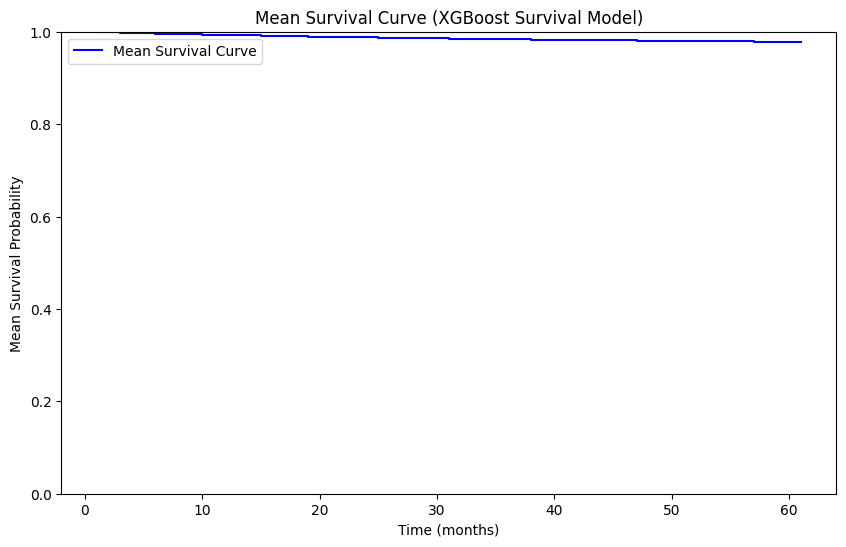

In [ ]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (XGBoost Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at time 12 months: 0.2335
Brier Score at time 36 months: 0.4442
Brier Score at time 60 months: 0.5368

Integrated Brier Score (IBS): 0.3714


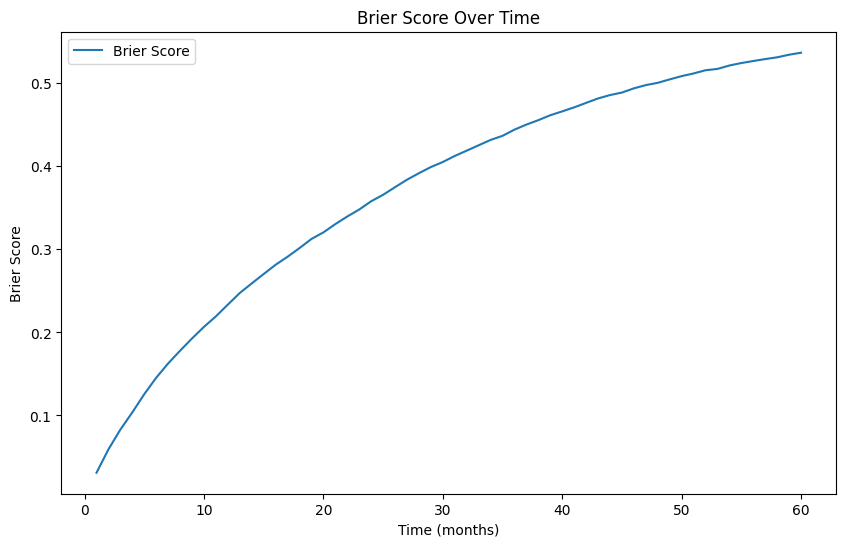

In [ ]:
# Define time points for the calculation (1 to 60 months)
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure alignment of survival probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)

# Adjust the survival probabilities to the desired time points (row by row)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])  # Interpolate the survival probabilities
    for i in range(survival_probabilities.shape[0])
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the index of the closest time point in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]

    # Get the actual observations (whether the event occurred at or after time 't')
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for the time 't'
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numeric value

    print(f"Brier Score at time {t} months: {brier[1][0]:.4f}")

# Calculate the Brier Score over time for the Integrated Brier Score (IBS)
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS)
time_differences = np.diff(np.hstack([[0], time_points]))  # Time differences between consecutive time points
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]  # Calculate the IBS
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, brier_scores[1], label="Brier Score")  # Plot Brier Score across time points
plt.xlabel("Time (months)")
plt.ylabel("Brier Score")
plt.title("Brier Score Over Time")
plt.legend()
plt.show()

In [ ]:
# Best features by permutation importance
calculate_permutation_importance_xgb(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.133244,0.002481
ANODIAG,0.024232,0.003391
TRATCONS_CAT,0.022133,0.001557
IDADE,0.020846,0.001296
CATEATEND,0.018466,0.001373
INSTITU,0.010910,0.000703
DIAGTRAT_CAT,0.006055,0.000791
DIAGPREV,0.004194,0.000560
ESCOLARI,0.004149,0.000499
IBGEATEN,0.004104,0.000471


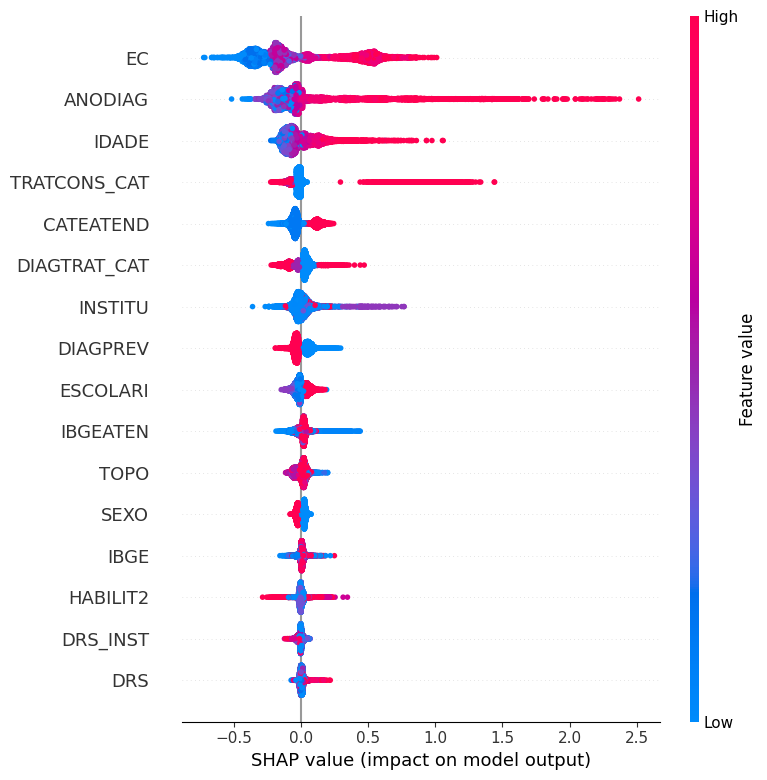

In [ ]:
# Create a SHAP TreeExplainer for the best model
explainer = shap.TreeExplainer(best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Generate a summary plot to visualize the SHAP values for each feature
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

### **LightGBM**

#### **Base Model**

In [ ]:
# LightGBM Model
dtrain = lgb.Dataset(X_train, label=y_train['time'],
                     weight=np.where(y_train['event'], 1.0, 0.15))  # Create a LightGBM dataset with event weights

# Define model parameters
params = {
    'objective': 'regression',  # LightGBM does not have direct survival support, using regression as a proxy
    'metric': 'rmse',           # Metric for monitoring (not used for survival analysis)
    'max_depth': 5,             # Maximum depth of trees
    'seed': seed,               # Set random seed for reproducibility
    'verbose': -1,              # Suppress output during training
    'n_jobs': -1                # Use all CPU cores for training
}

# Train the model
lgbm = lgb.train(params, dtrain, num_boost_round=100)  # Train the LightGBM model with 100 boosting rounds

# Make predictions (risk scores)
y_pred = lgbm.predict(X_test)  # Predict risk scores on the test data

# Evaluate the model using the C-Index (Test data)
c_index_base = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]  # Calculate C-Index for test data

# Evaluate the model using the C-Index (Train data)
y_pred_train = lgbm.predict(X_train)  # Predict risk scores on the training data
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]  # Calculate C-Index for training data

# Display the results
print(f'C-index Test: {c_index_base}')  # Print the C-Index for test data
print(f'C-index Train: {c_index_train}')  # Print the C-Index for train data

C-index Test: 0.72564403952883
C-index Train: 0.7438403445809474


In [ ]:
# C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = lgbm.predict(X_test)  # Predict survival risks for the test data
surv_risks_train = lgbm.predict(X_train)  # Predict survival risks for the training data

# Calculate the C-Index using IPCW for test data
c_index_ipcw = concordance_index_ipcw(y_train, y_test, -surv_risks)  # Evaluate the concordance index for test data

# Calculate the C-Index using IPCW for training data
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, -surv_risks_train)  # Evaluate the concordance index for training data

# Display the results for C-Index IPCW
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')  # Print the IPCW C-Index for test data
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')  # Print the IPCW C-Index for train data

C-Index IPCW Test: 0.719402090675295
C-Index IPCW Train: 0.7343812151099653


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(10, shuffle=True, random_state=seed)  # Split the data into 10 folds, shuffle data and set a random seed
c_index_list = []  # Initialize an empty list to store the C-Index scores for each fold

# Objective function for hyperparameter optimization
def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 130),  # Number of trees in the model
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25, step=0.01),  # Learning rate for boosting
        'max_depth': trial.suggest_int('max_depth', 3, 6),  # Maximum depth of the trees
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # Number of leaves in each tree
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),  # Minimum samples for each child node
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),  # Subsample ratio for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),  # Column sampling ratio for each tree
        'reg_alpha': trial.suggest_categorical('reg_alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10.0]),  # L1 regularization term
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10.0]),  # L2 regularization term
        'objective': 'regression',  # Set objective to regression (using Cox regression as a proxy)
        'metric': 'rmse',  # Metric for evaluation (Root Mean Squared Error)
        'seed': seed,  # Random seed
        'verbose': -1,  # Suppress output during training
        'n_jobs': -1  # Use all available CPU cores for parallel computation
    }

    # Loop through the folds for cross-validation
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data into training and validation sets based on the current fold
        X_t, X_v = X_train[train_idx], X_train[valid_idx]  # Training and validation features
        y_t, y_v = y_train[train_idx], y_train[valid_idx]  # Training and validation target labels

        # Create DMatrix for training data, using weights based on event occurrence
        dtrain = lgb.Dataset(X_t, label=y_t['time'], weight=np.where(y_t['event'], 1.0, 0.15))

        # Train the model using the current hyperparameters
        model = lgb.train(params, dtrain, num_boost_round=100)

        # Make predictions on the validation set
        pred_valid = model.predict(X_v)

        # Calculate the Concordance Index for the validation fold
        c_index = concordance_index_censored(y_v['event'], y_v['time'], -pred_valid)[0]
        c_index_list.append(c_index)  # Append the C-Index score to the list

    # Return the mean C-Index across all folds
    return np.mean(c_index_list)

**RandomSampler**

In [ ]:
# Hyperparameter optimization with Optuna - RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create an Optuna study with a random sampler for optimization
                            study_name='LGBM_RandomSampler')  # Name the study for identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using a random sampler

In [ ]:
# Display the best hyperparameters found during the optimization process
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 120, 'learning_rate': 0.18000000000000002, 'max_depth': 5, 'num_leaves': 99, 'min_child_samples': 15, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10.0}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the required model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Use regression (Cox model) for survival analysis
                    'metric': 'rmse',  # Metric for monitoring performance (Root Mean Squared Error)
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing if needed, but it's not used here

# Train the LightGBM model with the best parameters found by Optuna
lgbm_rand = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on the validation and training sets
y_pred = lgbm_rand.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_rand.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_rand = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_rand_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both test and training sets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {c_index_rand_train}')

C-Index Test: 0.7267607215129607
C-Index Train: 0.7517365220348216


**TPESampler**

In [ ]:
# Hyperparameter optimization with Optuna - TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create an Optuna study using the TPE sampler for optimization
                            study_name='LGBM_TPESampler')  # Name the study for easier identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using TPE with specified trials and parallel jobs

In [ ]:
# Display the best hyperparameters found during the optimization process
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 117, 'learning_rate': 0.13, 'max_depth': 6, 'num_leaves': 33, 'min_child_samples': 13, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'reg_lambda': 10.0}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the necessary model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Using Cox regression for survival analysis
                    'metric': 'rmse',  # Root Mean Squared Error metric for monitoring performance
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing, but it's not utilized in the current context

# Train the LightGBM model with the best parameters found by Optuna
lgbm_tpe = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on both the validation and training sets
y_pred = lgbm_tpe.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_tpe.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_tpe = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_tpe_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both the test and training sets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {c_index_tpe_train}')

C-Index Test: 0.7270517379376992
C-Index Train: 0.7530156153166119


**CmaEsSampler**

In [ ]:
# Hyperparameter optimization with Optuna - CmaEsSampler
study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create an Optuna study using the CMA-ES sampler for optimization
                            study_name='LGBM_CmaEsSampler')  # Name the study for easier identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using CMA-ES with specified trials and parallel jobs

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 79, 'learning_rate': 0.09, 'max_depth': 4, 'num_leaves': 37, 'min_child_samples': 17, 'subsample': 0.8500000000000001, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the necessary model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Using Cox regression for survival analysis
                    'metric': 'rmse',  # Root Mean Squared Error metric for monitoring performance
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing, but it's not utilized in the current context

# Train the LightGBM model with the best parameters found by Optuna
lgbm_cma = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on both the validation and training sets
y_pred = lgbm_cma.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_cma.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_cma = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_cma_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both the test and training sets
print(f'C-Index Test: {c_index_cma}')
print(f'C-Index Train: {c_index_cma_train}')

C-Index Test: 0.7202413533666217
C-Index Train: 0.7297314112250571


#### **Best LightGBM Model**

In [ ]:
# Best LightGBM Model Selection
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-Index scores for each model (base, random, TPE, CMA-ES)
models = [lgbm, lgbm_rand, lgbm_tpe, lgbm_cma]  # List of LightGBM models corresponding to each hyperparameter optimization approach

# Identify the model with the highest C-Index score
id_best_score = scores.index(max(scores))  # Find the index of the highest C-Index score
best = models[id_best_score]  # Select the model corresponding to the best score

# Display the best model
print(best)

In [ ]:
# Make predictions on the validation and training sets
y_pred = best.predict(X_test)  # Predict survival risks on the test set using the best model
y_pred_train = best.predict(X_train)  # Predict survival risks on the training set using the best model

# Calculate C-Index for the test set
final_c_index = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]  # Compute the concordance index for the test set
final_c_index_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]  # Compute the concordance index for the training set

# Display C-Index results
print('C-Index')
print(f'> Test: {final_c_index}')  # Print the C-Index for the test set
print(f'> Train: {final_c_index_train}')  # Print the C-Index for the training set

# Calculate the C-Index with Inverse Probability of Censoring Weighting (IPCW)
surv_risks = best.predict(X_test)  # Get the survival risks (predictions) for the test set
surv_risks_train = best.predict(X_train)  # Get the survival risks (predictions) for the training set

# Calculate IPCW C-Index
c_index_ipcw = concordance_index_ipcw(y_train, y_test, -surv_risks)  # Compute IPCW C-Index for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, -surv_risks_train)  # Compute IPCW C-Index for the training set

# Display IPCW C-Index results
print('\nC-Index IPCW')
print(f'> Test: {c_index_ipcw[0]}')  # Print IPCW C-Index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print IPCW C-Index for the training set

C-Index
> Test: 0.7270517379376992
> Train: 0.7530156153166119

C-Index IPCW
> Test: 0.7204456387820196
> Train: 0.7421101092955331


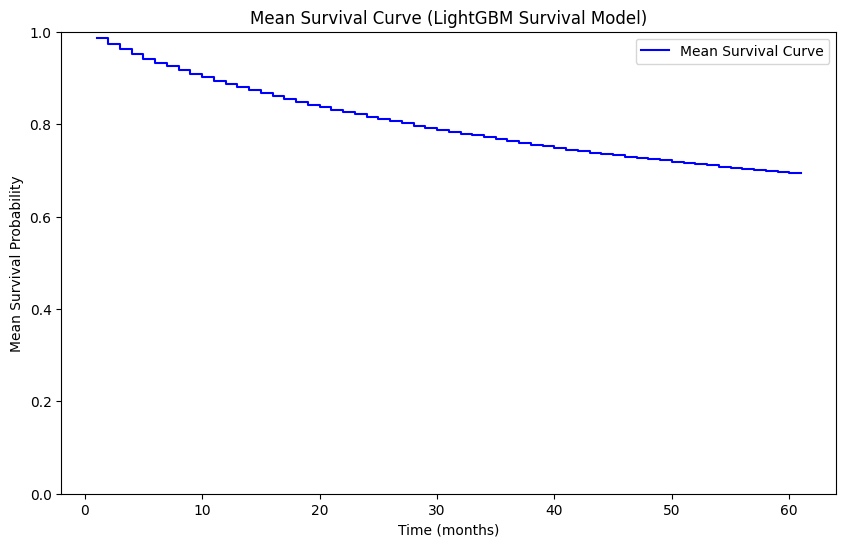

In [ ]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (LightGBM Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at 12 months: 0.2136
Brier Score at 36 months: 0.3404
Brier Score at 60 months: 0.3619

Integrated Brier Score (IBS): 0.2878


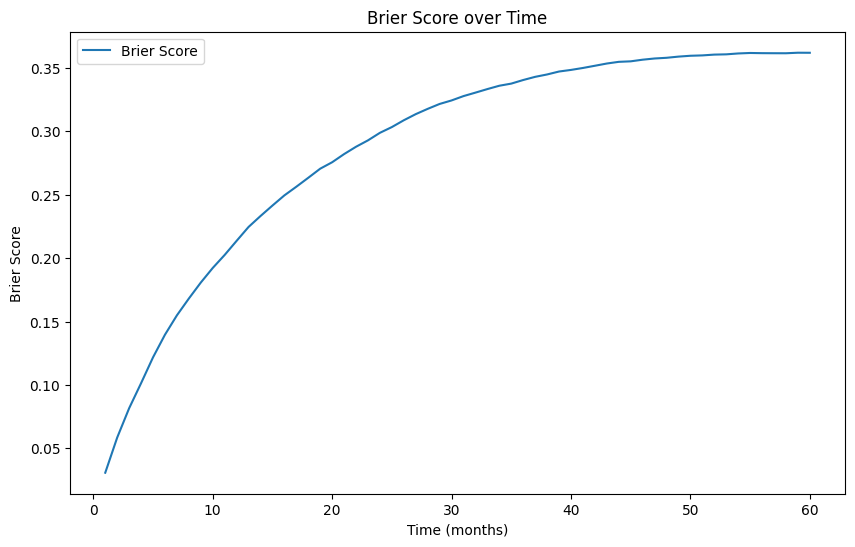

In [ ]:
# Define the time points for calculation, from 1 to 60 months
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure the alignment of survival_probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)  # Check that the number of time points matches

# Interpolate the survival probabilities to match the desired time points (line by line)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])  # Interpolate survival probabilities for each individual
    for i in range(survival_probabilities.shape[0])  # Loop over each individual
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the closest time index in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]  # Get the survival probabilities at the specified time point

    # Obtain the true values based on the actual event and time
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for the given time point t
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numerical Brier Score value

    print(f"Brier Score at {t} months: {brier[1][0]:.4f}")  # Print the Brier Score at the specific time point

# Calculate the Brier Score over the entire time range for the Integrated Brier Score (IBS)
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS) by summing the weighted Brier Scores over time
time_differences = np.diff(np.hstack([[0], time_points]))  # Compute time differences between consecutive time points
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]  # Calculate IBS
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")  # Print the Integrated Brier Score

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))  # Create a figure with the specified size
plt.plot(time_points, brier_scores[1], label="Brier Score")  # Plot Brier Score over time
plt.xlabel("Time (months)")  # Label the x-axis
plt.ylabel("Brier Score")  # Label the y-axis
plt.title("Brier Score over Time")  # Set the plot title
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

In [ ]:
# Best features by permutation importance
calculate_permutation_importance_lgbm(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.134753,0.002323
TRATCONS_CAT,0.027765,0.001174
ANODIAG,0.025259,0.003104
IDADE,0.023375,0.001243
CATEATEND,0.017098,0.001170
INSTITU,0.013643,0.000809
DIAGTRAT_CAT,0.008522,0.000513
ESCOLARI,0.005641,0.000545
TOPO,0.005345,0.000433
IBGEATEN,0.005004,0.000383


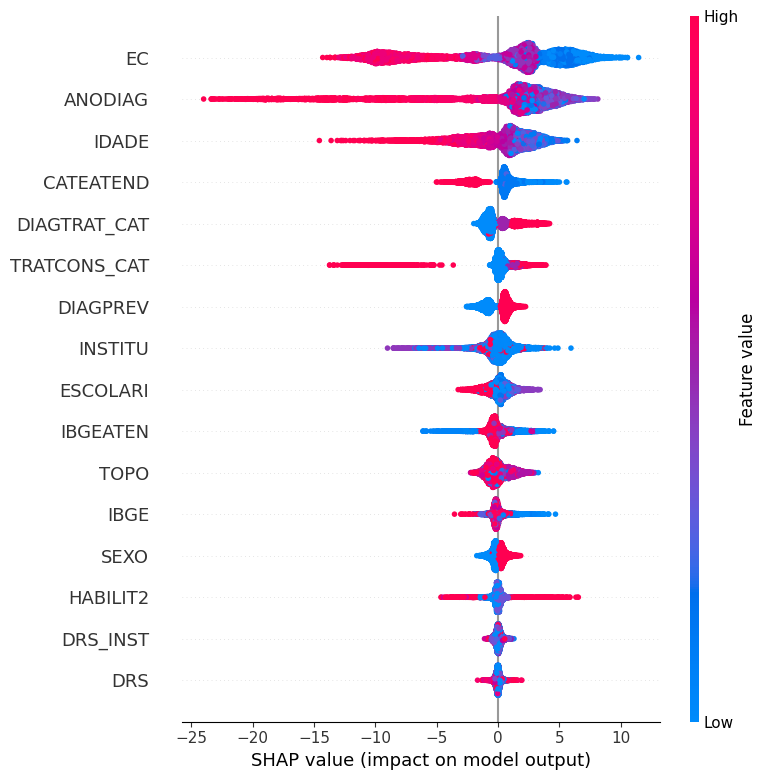

In [ ]:
# Create a SHAP TreeExplainer for the best model
explainer = shap.TreeExplainer(best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Generate a summary plot to visualize the SHAP values for each feature
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)